# Road surface detection and differentiation considering surface damages

## 1. Initial settings

---



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvid  ia-smi
!nvcc --version

/usr/bin/bash: /opt/bin/nvid: No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0


In [2]:
! pip install fastai==1.0.61

/home/aakashj2412/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/aakashj2412/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import fastai.vision
import torch
from fastai.vision import *
from fastai.vision.learner import *
from fastai.vision.interpret import *
# from fastai.vision.all import *
# from fastai.vision.interpret import *
# from fastai.callbacks.hooks.all import *
# from fastai.vision.all import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True
import numpy as np

In [3]:
print(fastai.__version__)

1.0.61


In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Preparing the data

---



In [7]:
import os
path = './RTK/unzipped'
file_list = os.listdir(path)
# print(file_list)

In [9]:
import os
file_list = os.listdir(path+'/zipped')
print(file_list)

['RTK_SemanticSegmentationGT_NoColorMapMasks.zip', 'RTK_SemanticSegmentationGT_coloredMasks.zip', 'RTK_SemanticSegmentationGT_Json.zip', 'RTK_SemanticSegmentationGT_originalFrames.zip']


In [10]:
import os
file_list = os.listdir(path+'/zipped')
print(file_list)

['RTK_SemanticSegmentationGT_NoColorMapMasks.zip', 'RTK_SemanticSegmentationGT_coloredMasks.zip', 'RTK_SemanticSegmentationGT_Json.zip', 'RTK_SemanticSegmentationGT_originalFrames.zip']


In [ ]:
import zipfile
fname = path + "/zipped/" + file_list[3]
with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall(path + "/unzipped/" + file_list[3].replace(".zip",""))

In [11]:
path = 'gdrive/MyDrive/RTK/unzipped/'
file_list = os.listdir(path)
print(file_list)

['RTK_SemanticSegmentationGT_Json', 'images', 'labels', 'colorLabels', 'codes.txt', 'valid.txt']


In [5]:
path = Path('./RTK/unzipped')
path.ls()

[PosixPath('RTK/unzipped/RTK_SemanticSegmentationGT_Json'),
 PosixPath('RTK/unzipped/labels'),
 PosixPath('RTK/unzipped/codes.txt'),
 PosixPath('RTK/unzipped/colorLabels'),
 PosixPath('RTK/unzipped/images'),
 PosixPath('RTK/unzipped/valid.txt')]

In [6]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved', 'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'craks'], dtype='<U12')

In [7]:
path_lbl = path/'labels'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

701

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)

701

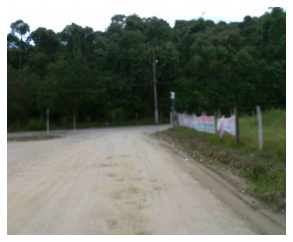

In [10]:
img_f = fnames[139]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

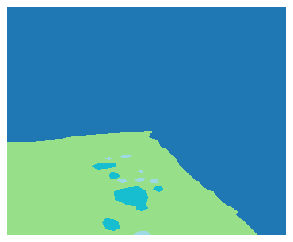

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([288, 352]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [3, 3, 3,  ..., 0, 0, 0],
          [3, 3, 3,  ..., 0, 0, 0],
          [3, 3, 3,  ..., 0, 0, 0]]]))

## 3. First Step - Without weights

---



### 3.1. First step Datasets

---



In [15]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 4035MB of GPU RAM free


In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/home/aakashj2412/.local/lib/python3.8/site-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


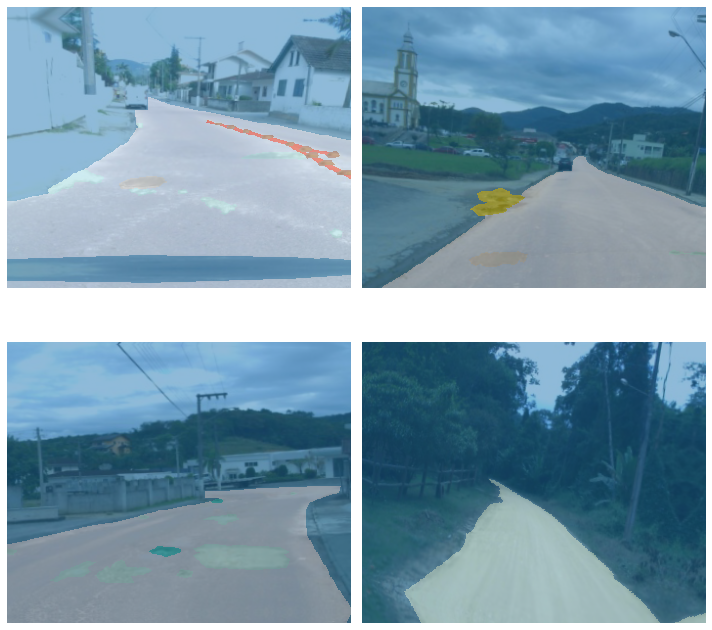

In [18]:
data.show_batch(2, figsize=(10,10))

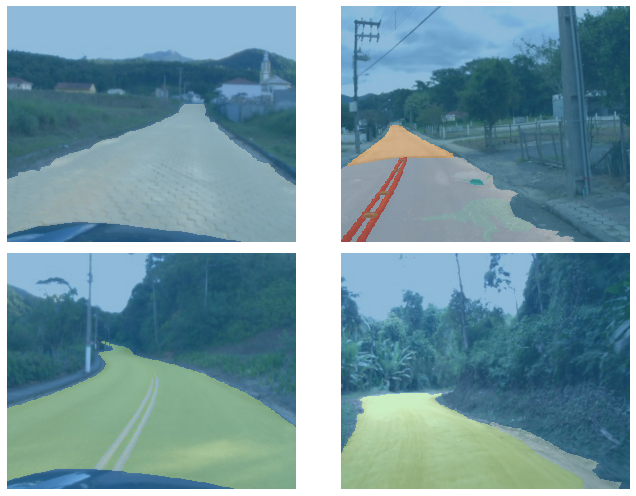

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 3.2. First step Model

---



In [20]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_rtk
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


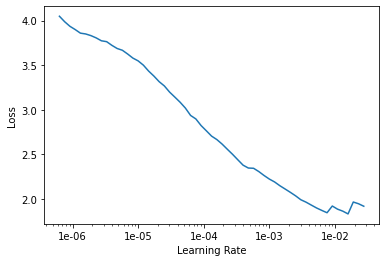

In [26]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-4

In [23]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.9)

In [24]:
learn.save('stage-1')

In [34]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (561 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: RTK/unzipped/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: RTK/unzipped/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
   

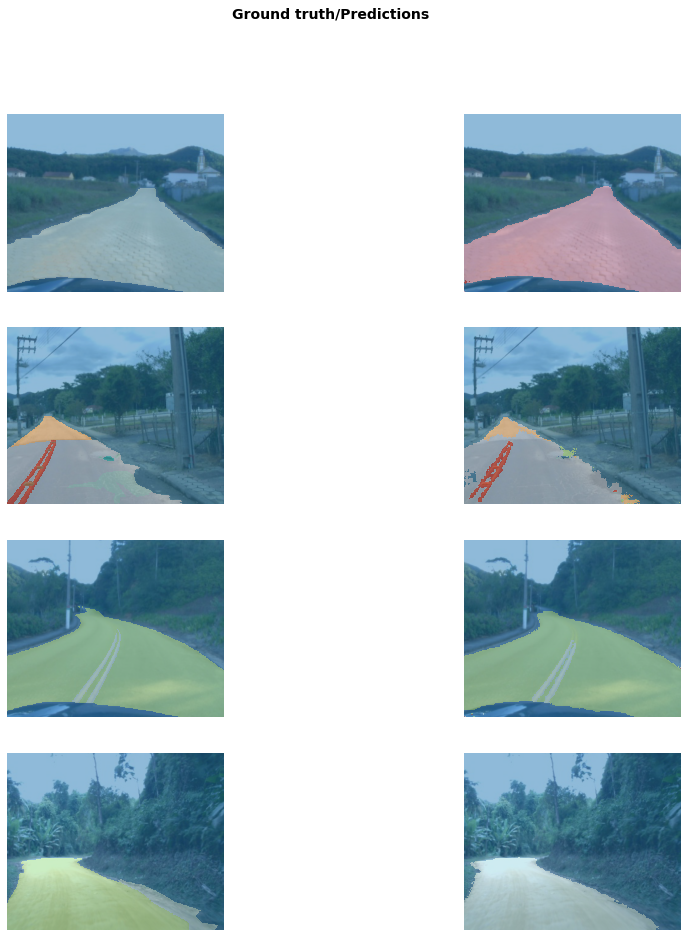

In [35]:
learn.show_results(rows=5, figsize=(15,15))

### 3.3. Interpret

---



In [36]:
interp = SegmentationInterpretation.from_learner(learn)

In [37]:
top_losses, top_idxs = interp.top_losses((288,352))

(array([65., 24., 11., 12., 11.,  5.,  1.,  4.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([0.015093, 0.064821, 0.114549, 0.164277, 0.214006, 0.263734, 0.313462, 0.36319 , 0.412918, 0.462647, 0.512375,
        0.562103, 0.611831, 0.66156 , 0.711288, 0.761016, 0.810744, 0.860473, 0.910201, 0.959929, 1.009657],
       dtype=float32),
 <BarContainer object of 20 artists>)

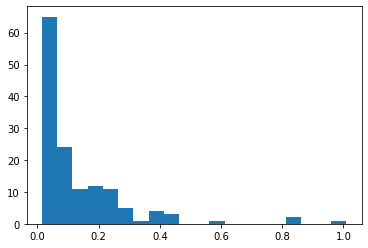

In [38]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [39]:
# top loss idxs of images
top_idxs[:5]

tensor([  6,  92,  11, 123, 114])

### 3.4. Confusion Matrix

---



In [40]:
mean_cm, single_img_cm = interp._generate_confusion()

In [41]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

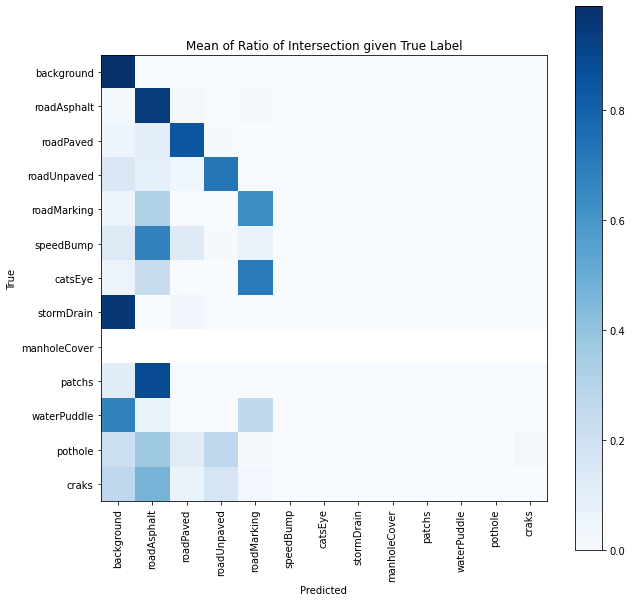

In [42]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

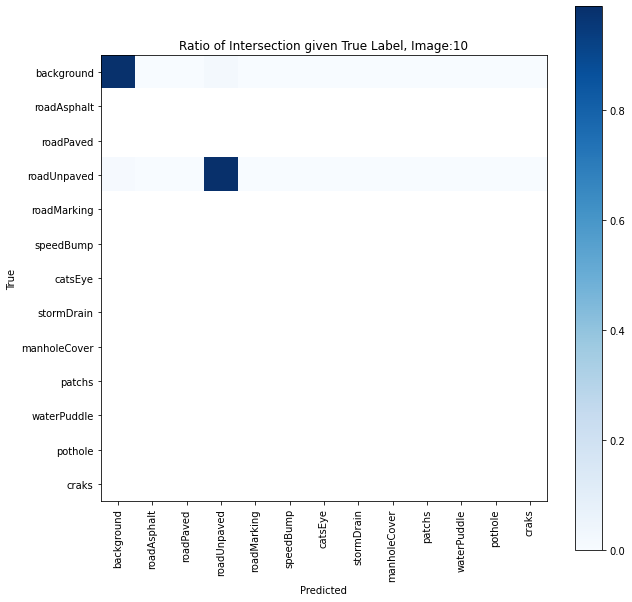

In [43]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

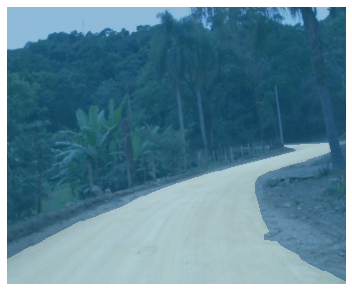

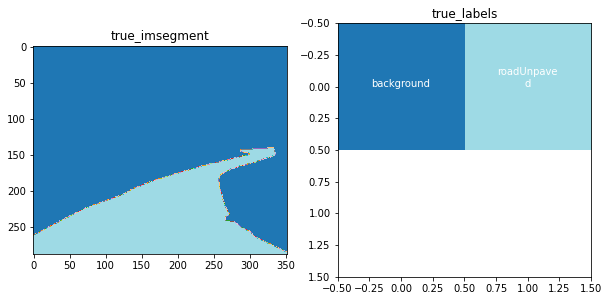

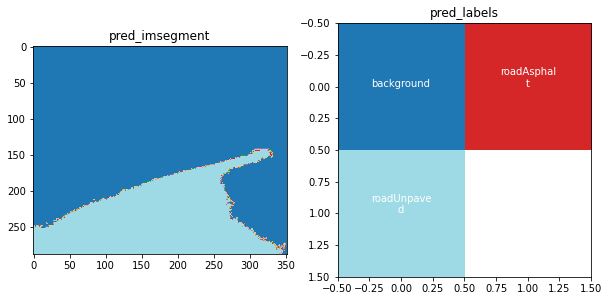

In [44]:
# show xyz
interp.show_xyz(i)

### 3.5. First model continuation

---



In [24]:
learn.unfreeze()

In [25]:
lrs = slice(lr/400,lr/4)

In [26]:
learn.fit_one_cycle(40, lrs, pct_start=0.9)

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 3.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 0
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.7. Interpret

---



In [ ]:
learn.interpret

### 3.8. Saving

---



In [ ]:
learn.save('stage-2')

In [ ]:
data=None
learn=None
gc.collect()

## 4. Second Step - With weights

---



### 4.1. Second step Datasets

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 2200MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

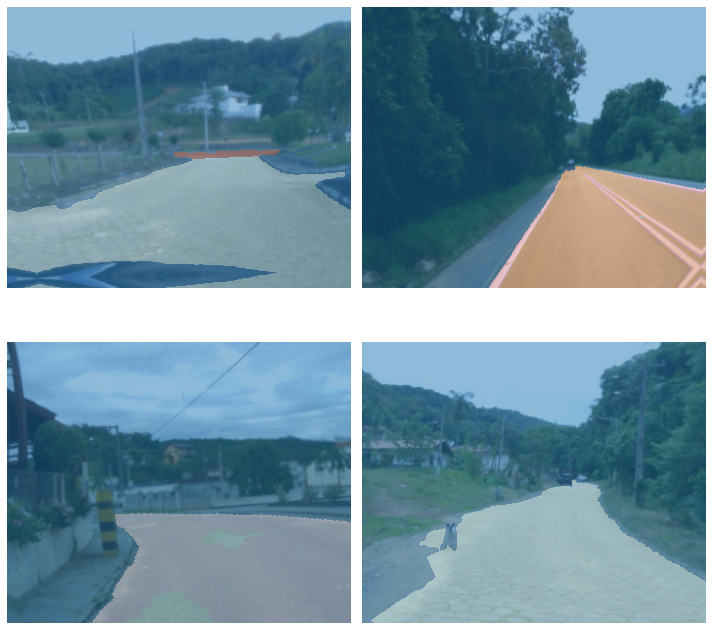

In [ ]:
data.show_batch(2, figsize=(10,10))

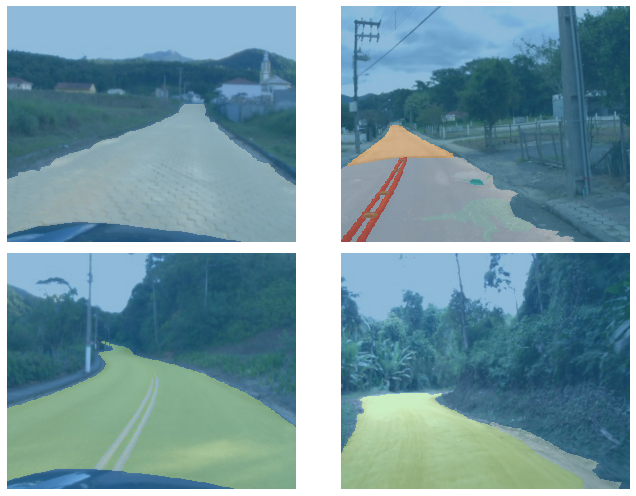

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 4.2. Second step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)

In [ ]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (561 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: RTK/unzipped/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: RTK/unzipped/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
   

In [ ]:
!/opt/bin/nvidia-smi

/usr/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1-weights')

In [ ]:
learn.load('stage-1-weights')

Learner(data=ImageDataBunch;

Train: LabelList (561 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: RTK/unzipped/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: RTK/unzipped/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
   

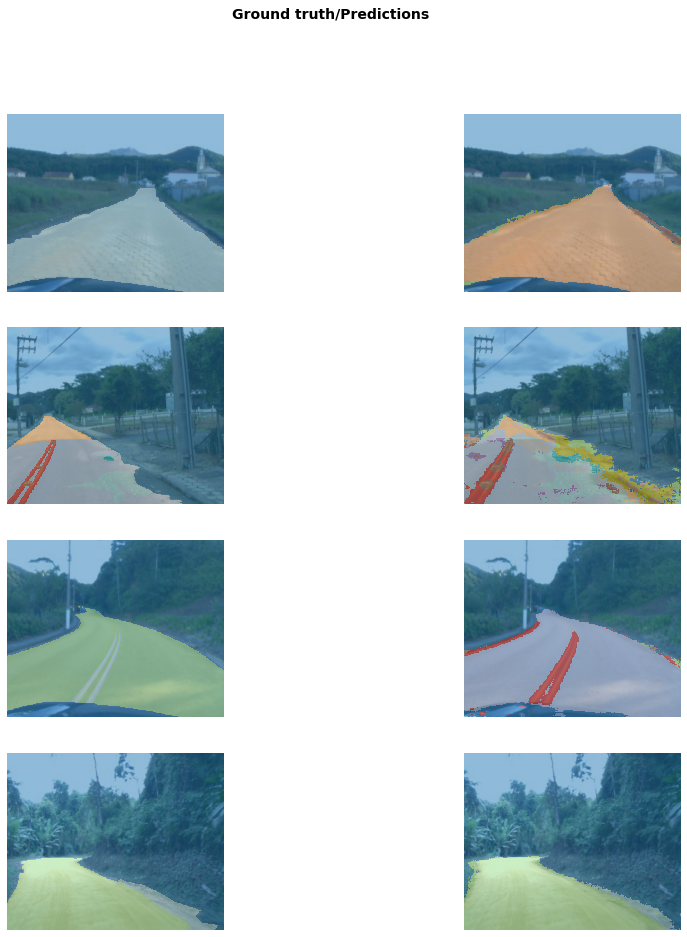

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 4.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((288,352))

(array([102.,  16.,   7.,   5.,   2.,   1.,   2.,   1.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.]),
 array([ 0.081476,  3.37657 ,  6.671665,  9.96676 , 13.261854, 16.55695 , 19.852043, 23.147139, 26.442232, 29.737328,
        33.03242 , 36.327515, 39.622612, 42.917706, 46.2128  , 49.507896, 52.80299 , 56.098083, 59.393177, 62.688274,
        65.98337 ], dtype=float32),
 <BarContainer object of 20 artists>)

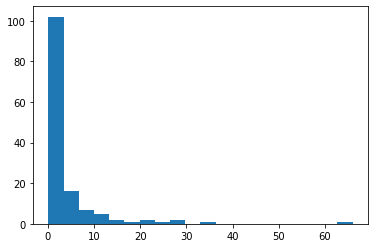

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

tensor([115, 131, 112,  30, 117])

### 4.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

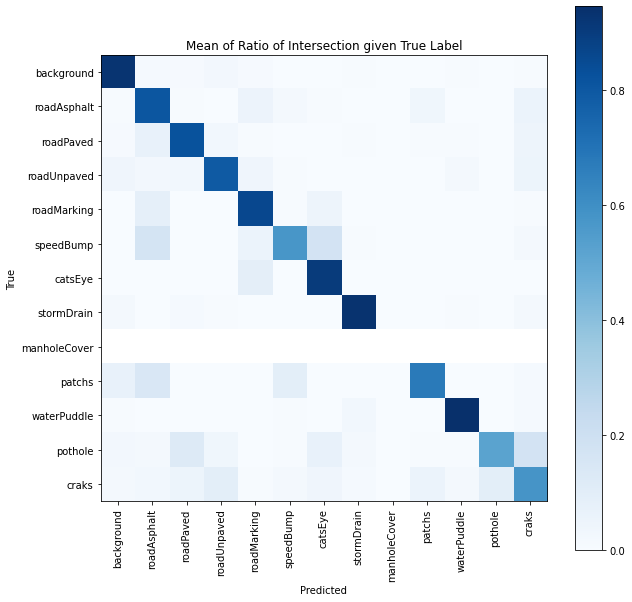

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

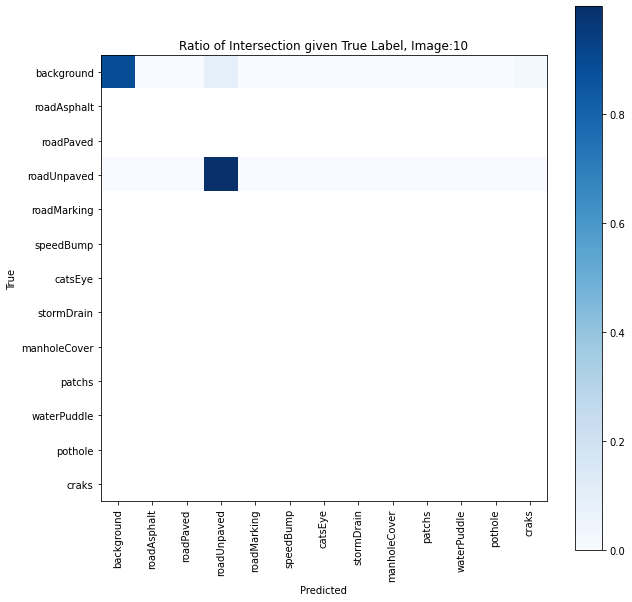

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

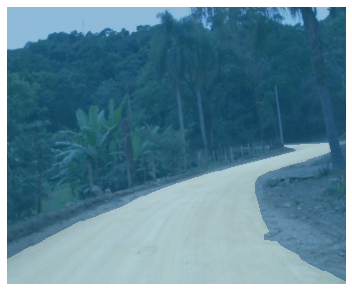

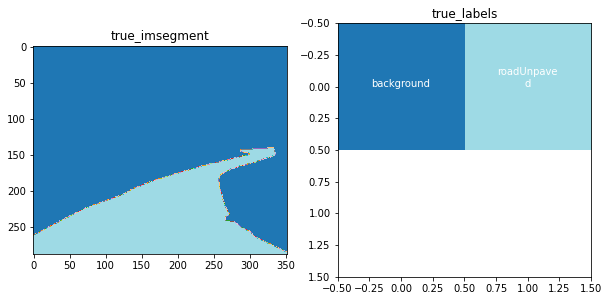

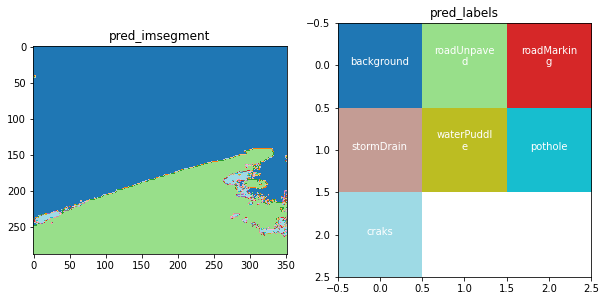

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.5. Second model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(40, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2-weights')

In [ ]:
learn.load('stage-2-weights')

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 4.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.7. Interpret

---



In [ ]:
learn.interpret

### 4.8. Saving

---



In [ ]:
learn.save('stage-2-weights')

## 5. Using a saved model to Predict

---



In [79]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 1850MB of GPU RAM free


In [80]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [81]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [141]:
print(type(data))

<class 'fastai.vision.data.ImageDataBunch'>


: 

In [82]:
learn = unet_learner(data, models.resnet34)

In [83]:
learn.load('stage-1-weights')

In [84]:
interp = SegmentationInterpretation.from_learner(learn)

In [85]:
mean_cm, single_img_cm = interp._generate_confusion()

In [86]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

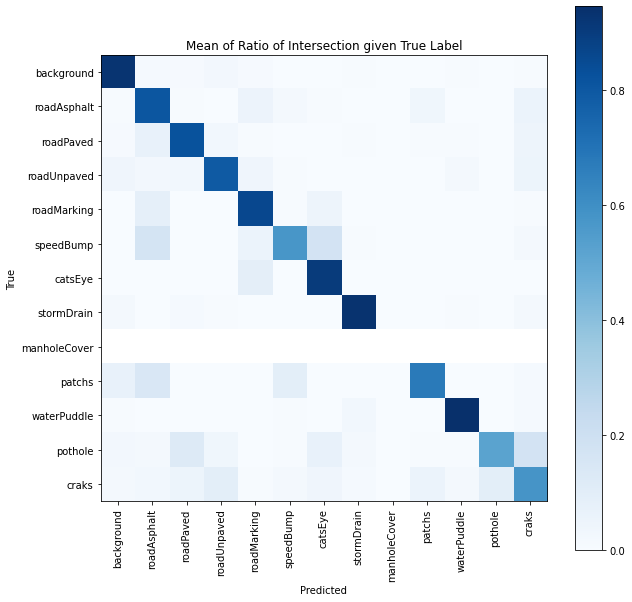

In [87]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

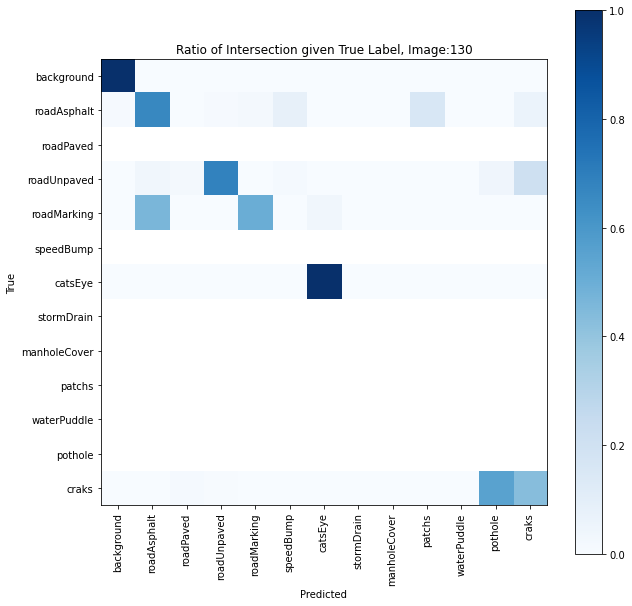

In [88]:
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

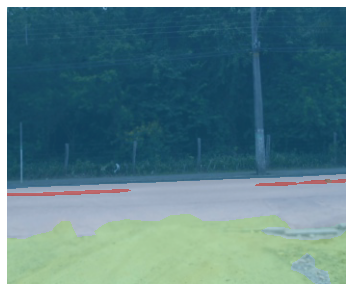

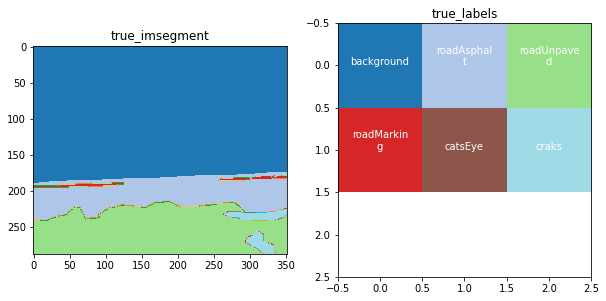

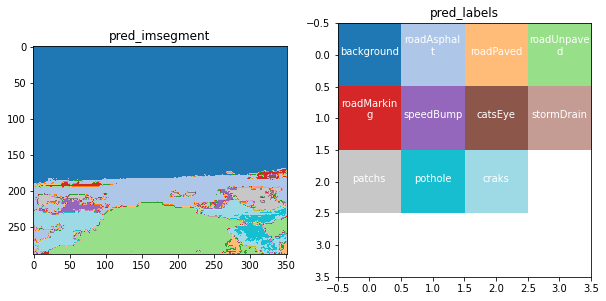

In [89]:
# show xyz
interp.show_xyz(i)

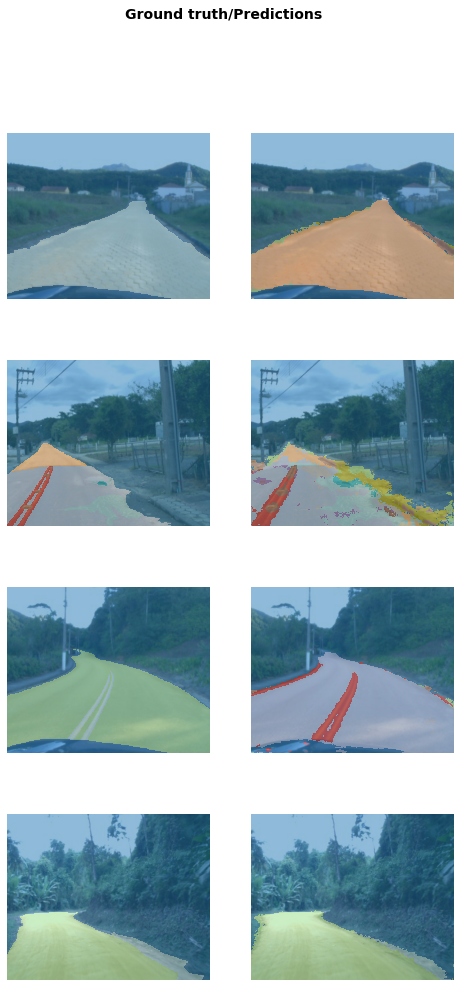

In [90]:
learn.show_results()

## 6. Saving the Results

---



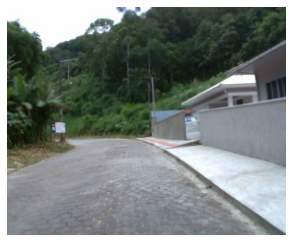

In [91]:
img_f = fnames[655]
img = open_image(img_f)
img.show(figsize=(5,5))

In [92]:
prediction = learn.predict(img)

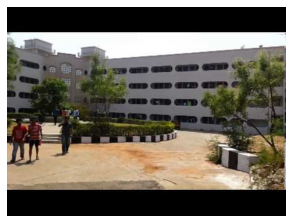

In [138]:
img = open_image('iiith.jpg')
img.show(figsize=(5,5))

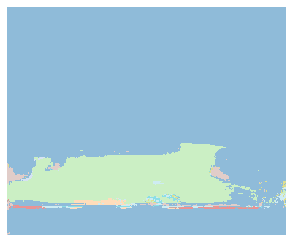

In [139]:
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))

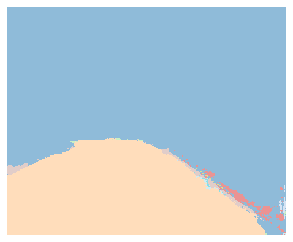

In [93]:
prediction[0].show(figsize=(5,5))

In [127]:
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)

In [128]:
print(fnames[0])

RTK/unzipped/images/000000607.png


In [129]:
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        img_split = img_split[20:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)

In [130]:
save_preds(fnames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## 7. Coloring the Results

---




In [131]:
!pip install Cython

/home/aakashj2412/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/aakashj2412/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [132]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.6.0'

In [133]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [134]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [135]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [136]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)
  cv.imshow('frame',frame)

  fqtd += 1
  print(fqtd)

print("Done!")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
